In [8]:
import os
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
# Specify the directory path where your files are located
directory_path = 'FUMA_downloads_all_tissue/eQTLs'

# Initialize an empty list to store DataFrames
df_list = []

# Initialize an empty list to store disorder names
disorder_names = []

# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.txt'):  # Process only .txt files
        # Extract disorder name from the filename
        disorder_name = filename.split('_')[1].split('.')[0]
        disorder_names.append(disorder_name)

        # Read the file as a DataFrame
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path, sep='\t')

        # Add a column with the disorder name
        df['disorder'] = disorder_name

        # Append the DataFrame to the list
        df_list.append(df)

C:\Users\annei\AppData\Local\Temp\ipykernel_13476\1702456898.py:19: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_13476\1702456898.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_13476\1702456898.py:19: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_13476\1702456898.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')
C:\Users\annei\AppData\Local\Temp\ipykernel_13476\1702456898.py:19: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=Fal

In [4]:
# Extract unique gene identifiers and DataFrame names
unique_genes = pd.concat([df['gene'] for df in df_list], ignore_index=True).drop_duplicates()


# Create a dictionary to store the SNP data for each DataFrame
gene_data = {}
for df, df_name in zip(df_list, disorder_names):
    gene_data[df_name] = df['gene'].tolist()

# Create a new DataFrame with unique gene identifiers as rows and DataFrame names as columns
result_df = pd.DataFrame(index=unique_genes, columns=disorder_names)

# Fill in the DataFrame with gene data
for df_name in disorder_names:
    result_df.loc[gene_data[df_name], df_name] = 1

# Fill NaN values with 0
result_df.fillna(0, inplace=True)
result_df.index.name= None

In [ ]:
#function to make a matrix with p-values between disorders and genes
def p_value_matrix(dfs, df_names):
    # Extract unique gene identifiers and DataFrame names
    unique_genes = pd.concat([df['gene'] for df in dfs if 'gene' in df.columns],
                             ignore_index=True).drop_duplicates()

    # Create a dictionary to store the gene data for each DataFrame
    genes_data = {}
    for df, df_name in zip(dfs, df_names):
        if 'gene' in df.columns:
            genes_data[df_name] = df[df['gene'].isin(unique_genes)]['gene'].tolist()

    # Create a new DataFrame with unique gene identifiers as rows and DataFrame names as columns
    result_df = pd.DataFrame(index=unique_genes, columns=df_names)

    # Fill in the DataFrame with gene data
    for df_name in df_names:
        if df_name in genes_data:
            result_df.loc[genes_data[df_name], df_name] = dfs[df_names.index(df_name)]['p'].values

    # Fill NaN values with 0
    result_df.fillna(0, inplace=True)

    result_df.index.name = None

    return result_df

In [ ]:
p_val_genes = p_value_matrix(df_list, disorder_names)

In [ ]:
p_val_genes.head()

In [ ]:
result_df.head()

In [ ]:
result_df.to_csv('output/eqtl_all_binary.txt', sep='\t')

In [ ]:
print(np.shape(result_df))

In [ ]:
result_df.sum(axis=0)

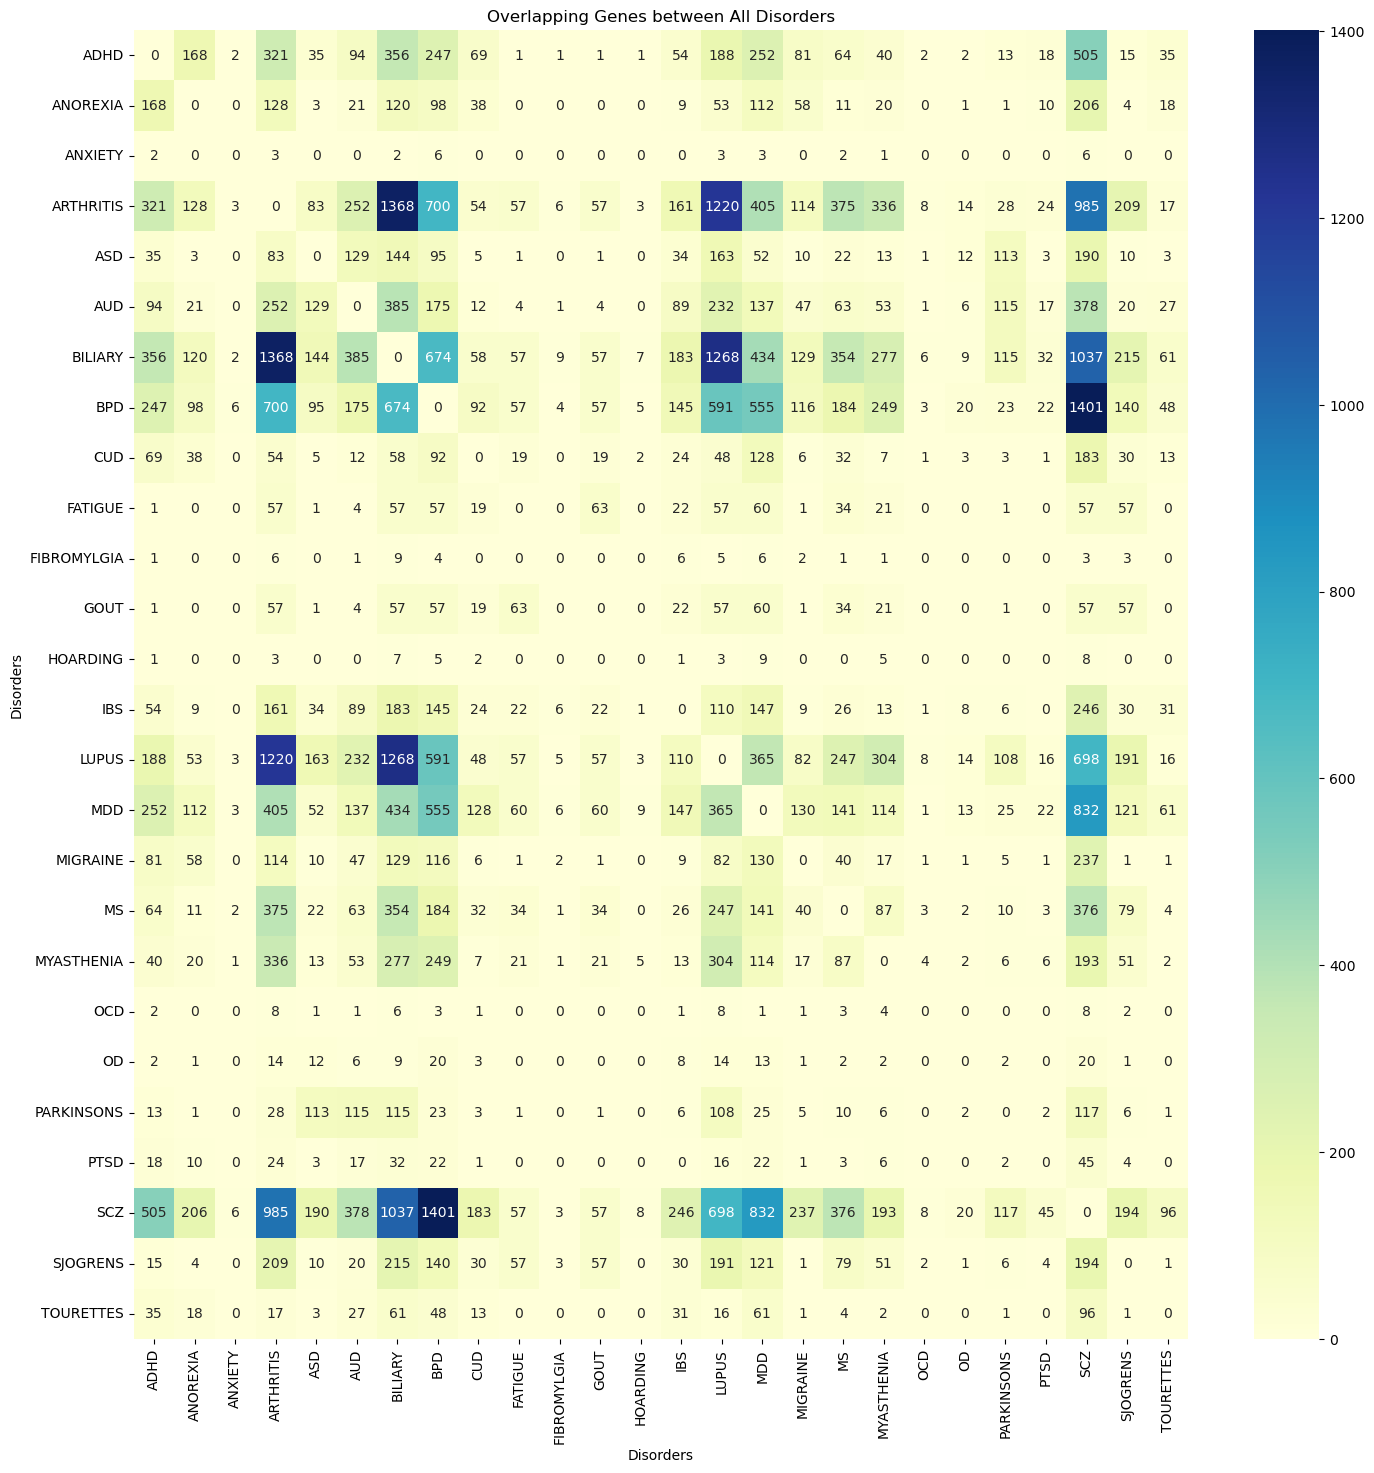

In [9]:
# Find overlapping SNPs between disorders
overlapping_snps = {}
for disorder1 in result_df.columns:
    overlapping_snps[disorder1] = []
    for disorder2 in result_df.columns:
        if disorder1 != disorder2:
            # Check for overlapping SNPs between two disorders
            common_snps = result_df[(result_df[disorder1] == 1) & (result_df[disorder2] == 1)].index.tolist()
            if common_snps:
                overlapping_snps[disorder1].append((disorder2, common_snps))

# Create a matrix to represent the overlaps between disorders
overlap_matrix = pd.DataFrame(index=overlapping_snps.keys(), columns=overlapping_snps.keys(), data=0)

# Fill the overlap matrix with the count of overlapping SNPs between disorders
for disorder, overlaps in overlapping_snps.items():
    for other_disorder, snps in overlaps:
        overlap_matrix.loc[disorder, other_disorder] = len(snps)

# Plotting the heatmap
plt.figure(figsize=(17,17))
sns.heatmap(overlap_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Overlapping Genes between All Disorders")
plt.xlabel("Disorders")
plt.ylabel("Disorders")
plt.show()